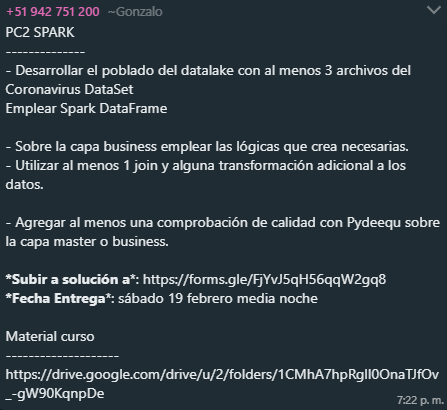

Relación de los Datasets
mas información: https://www.kaggle.com/kimjihoo/coronavirusdataset?select=SearchTrend.csv

<img src='https://miro.medium.com/max/1400/0*RVqtYcbfYPdKuU2L.PNG' width=700>

In [1]:
import findspark

findspark.init()
findspark.find()

'E:\\LibreriasPython\\spark-3.0.2-bin-hadoop2.7-hive1.2\\python\\pyspark'

In [7]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [5]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession.builder.appName('spark_Pipeline').getOrCreate()

## 1. **Capa Landing**
-------------------------

In [6]:
import os
import shutil

# Creamos zonas data lake
folders = ['landing', 'raw', 'master', 'business']
for folder in folders:
    os.mkdir(folder)
    
print(os.getcwd())
print(os.listdir())

E:\Repositorio\Pyspark\Pipeline
['.ipynb_checkpoints', 'business', 'landing', 'master', 'PatientInfo.csv', 'pipelineCoronavirus.ipynb', 'raw', 'Region.csv', 'Weather.csv']


In [7]:
for file in os.listdir():
  if '.csv' in file:
    shutil.move(file, f'./landing/{file}')

## 2. **Capa Raw**
-------------------------

In [16]:
from pyspark.sql import functions as F
from datetime import datetime
options = {
    'header': True,
    'sep': ','
}

In [18]:
from pyspark.sql.types import StringType, StructType,StructField
schemas = []

schemaPatientInfo = StructType([
    StructField("patient_id",StringType()),
    StructField("sex",StringType()),
    StructField("age",StringType()),
    StructField("country",StringType()),
    StructField("province",StringType()),
    StructField("city",StringType()),
    StructField("infection_case",StringType()),
    StructField("infected_by",StringType()),
    StructField("contact_number",StringType()),
    StructField("symptom_onset_date",StringType()),
    StructField("confirmed_date",StringType()),
    StructField("released_date",StringType()),
    StructField("deceased_date",StringType()),
    StructField("state",StringType()),
])

schemaRegion = StructType([ 
    StructField("code",StringType()),
    StructField("province",StringType()),
    StructField("city",StringType()),
    StructField("latitude",StringType()),
    StructField("longitude",StringType()),
    StructField("elementary_school_count",StringType()),
    StructField("kindergarten_count",StringType()),
    StructField("university_count",StringType()),
    StructField("academy_ratio",StringType()),
    StructField("elderly_population_ratio",StringType()),
    StructField("elderly_alone_ratio",StringType()),
    StructField("nursing_home_count",StringType()),
])


schemaWeather = StructType([ 
    StructField("code",StringType()),
    StructField("province",StringType()),
    StructField("date",StringType()),
    StructField("avg_temp",StringType()),
    StructField("min_temp",StringType()),
    StructField("max_temp",StringType()),
    StructField("precipitation",StringType()),
    StructField("max_wind_speed",StringType()),
    StructField("most_wind_direction",StringType()),
    StructField("avg_relative_humidity",StringType()),
])

schemas.append(schemaPatientInfo)
schemas.append(schemaRegion)
schemas.append(schemaWeather)

schemas

[StructType(List(StructField(patient_id,StringType,true),StructField(sex,StringType,true),StructField(age,StringType,true),StructField(country,StringType,true),StructField(province,StringType,true),StructField(city,StringType,true),StructField(infection_case,StringType,true),StructField(infected_by,StringType,true),StructField(contact_number,StringType,true),StructField(symptom_onset_date,StringType,true),StructField(confirmed_date,StringType,true),StructField(released_date,StringType,true),StructField(deceased_date,StringType,true),StructField(state,StringType,true))),
 StructType(List(StructField(code,StringType,true),StructField(province,StringType,true),StructField(city,StringType,true),StructField(latitude,StringType,true),StructField(longitude,StringType,true),StructField(elementary_school_count,StringType,true),StructField(kindergarten_count,StringType,true),StructField(university_count,StringType,true),StructField(academy_ratio,StringType,true),StructField(elderly_population_ra

In [2]:
class classELT:
    def __init__(self, path: str):
        self.path = path
    
    def extract_df(self, schema, options):
        self.extractDf = spark.read.options(**options).schema(schema).csv(self.path)

    def transform_df(self):
        self.transformDf= (self.extractDf.withColumn( 'auditDate', 
                                F.to_timestamp( F.lit(datetime.now())) 
                      ))
    def load_df(self, out_path):
        df =  self.transformDf
        df.write.mode('overwrite').parquet(out_path)

In [21]:
outPath ="raw/"
path = "landing/"
filesNames = ["PatientInfo","Region","Weather"]
# ETL
for i in range(0,3):
    tempDataFrame = classELT(path+filesNames[i]+".csv")
    tempDataFrame.extract_df(schemas[i],options)
    tempDataFrame.transform_df()
    tempDataFrame.load_df(outPath+filesNames[i]+"_raw")

## 3. **Capa Master**
-------------------------

In [56]:
class classELT_Master:
    def __init__(self, path: str):
        self.path = path
    
    def extract_df(self, schema):
        self.extractDf = spark.read.schema(schema).parquet(self.path)
    
    def transform_df(self,dic):
        self.transformDf = self.extractDf 
        if len(dic) > 0:
            for key,value in dic.items():
                self.transformDf = self.transformDf.withColumn(key, F.col(key).cast(value))
        
        self.transformDf = (self.transformDf.withColumn( 'auditDate', 
                                F.to_timestamp( F.lit(datetime.now())))) 
    def load_df(self, out_path):
        df =  self.transformDf
        df.write.mode('overwrite').parquet(out_path)
                                                

In [76]:
from pyspark.sql.types import StructField, StructType, StringType, TimestampType, IntegerType,BooleanType, FloatType,TimestampType,DateType
dics = []

dic_patineInfo ={
    "patient_id":IntegerType(),
    "sex":StringType(),
    "age":StringType(),
    "country":StringType(),
    "province":StringType(),
    "city":StringType(),
    "infection_case":StringType(),
    "infected_by":IntegerType(),
    "contact_number":IntegerType(),
    "symptom_onset_date":DateType(),
    "confirmed_date":DateType(),
    "released_date":DateType(),
    "deceased_date":DateType(),
    "state":StringType()
}  

dic_region = {
    "code":IntegerType(),
    "province":StringType(),
    "city":StringType(),
    "latitude":FloatType(),
    "longitude":FloatType(),
    "elementary_school_count":IntegerType(),
    "kindergarten_count":IntegerType(),
    "university_count":IntegerType(),
    "academy_ratio":FloatType(),
    "elderly_population_ratio":FloatType(),
    "elderly_alone_ratio":FloatType(),
    "nursing_home_count":IntegerType()
}

dic_weather = {
    "code":IntegerType(),
    "province":StringType(),
    "date":DateType(),
    "avg_temp":FloatType(),
    "min_temp":FloatType(),
    "max_temp":FloatType(),
    "precipitation":FloatType(),
    "max_wind_speed":FloatType(),
    "most_wind_direction":IntegerType(),
    "avg_relative_humidity":FloatType()
}

dics.append(dic_patineInfo)
dics.append(dic_region)
dics.append(dic_weather)
print(dics)

[{'patient_id': IntegerType, 'sex': StringType, 'age': StringType, 'country': StringType, 'province': StringType, 'city': StringType, 'infection_case': StringType, 'infected_by': IntegerType, 'contact_number': IntegerType, 'symptom_onset_date': DateType, 'confirmed_date': DateType, 'released_date': DateType, 'deceased_date': DateType, 'state': StringType}, {'code': IntegerType, 'province': StringType, 'city': StringType, 'latitude': FloatType, 'longitude': FloatType, 'elementary_school_count': IntegerType, 'kindergarten_count': IntegerType, 'university_count': IntegerType, 'academy_ratio': FloatType, 'elderly_population_ratio': FloatType, 'elderly_alone_ratio': FloatType, 'nursing_home_count': IntegerType}, {'code': IntegerType, 'province': StringType, 'date': DateType, 'avg_temp': FloatType, 'min_temp': FloatType, 'max_temp': FloatType, 'precipitation': FloatType, 'max_wind_speed': FloatType, 'most_wind_direction': IntegerType, 'avg_relative_humidity': FloatType}]


In [82]:
outPath ="master/"
path = "raw/"

for i in range(0,3):
    rawDataFrame = classELT_Master(path+filesNames[i]+"_raw/")
    rawDataFrame.extract_df(schemas[i])
    rawDataFrame.transform_df(dics[i])
    rawDataFrame.transformDf.printSchema()
    rawDataFrame.load_df(outPath+filesNames[i]+"_master")

root
 |-- patient_id: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: string (nullable = true)
 |-- country: string (nullable = true)
 |-- province: string (nullable = true)
 |-- city: string (nullable = true)
 |-- infection_case: string (nullable = true)
 |-- infected_by: integer (nullable = true)
 |-- contact_number: integer (nullable = true)
 |-- symptom_onset_date: date (nullable = true)
 |-- confirmed_date: date (nullable = true)
 |-- released_date: date (nullable = true)
 |-- deceased_date: date (nullable = true)
 |-- state: string (nullable = true)
 |-- auditDate: timestamp (nullable = false)

root
 |-- code: integer (nullable = true)
 |-- province: string (nullable = true)
 |-- city: string (nullable = true)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- elementary_school_count: integer (nullable = true)
 |-- kindergarten_count: integer (nullable = true)
 |-- university_count: integer (nullable = true)
 |-- academy_rat

## **4. Poblado Capa Business**

In [80]:
def extract_df(path,schema):
    return spark.read.schema(schema).parquet(path)
    
def transform_audit_df(df,self):
    return self.df.withColumn( 'auditDate', F.to_timestamp( F.lit(datetime.now()))) 

def load_df(df, out_path):
    df.write.mode('overwrite').parquet(out_path)

In [202]:
patientInfo_schema = StructType([
    StructField("patient_id",IntegerType()),
    StructField("sex",StringType()),
    StructField("age",StringType()),
    StructField("country",StringType()),
    StructField("province",StringType()),
    StructField("city",StringType()),
    StructField("infection_case",StringType()),
    StructField("infected_by",IntegerType()),
    StructField("contact_number",IntegerType()),
    StructField("symptom_onset_date",DateType()),
    StructField("confirmed_date",DateType()),
    StructField("released_date",DateType()),
    StructField("deceased_date",DateType()),
    StructField("state",StringType())
])

new_patientInfoDF = extract_df("master/"+filesNames[0]+"_master",patineInfo_schema)
  
# No tomamos en cuenta 4 columnas "released_date","contact_number","deceased_date","infected_by"
columnsExclude_patientInfo = {"released_date","contact_number","deceased_date","infected_by"}
new_patientInfoDF = new_patientInfoDF.select([c for c in new_patientInfoDF.columns if c not in columnsExclude_patientInfo ])

# Eliminamos los nulls de symptom_onset_date y las edades nulas
condicional = (new_patientInfoDF.age.isNotNull() & new_patientInfoDF.symptom_onset_date.isNotNull())
new_patientInfoDF = new_patientInfoDF.filter(condicional)

# Convertir la edad de string a entero usando UDF
from pyspark.sql.functions import udf
@udf("integer")
def castStringToInteger_Age(age: str) -> int:
    return int(age[:-1])

new_patientInfoDF = new_patientInfoDF.withColumn("age",F.lit(castStringToInteger_Age(new_patientInfoDF.age)))


new_patientInfoDF.show(5)

+----------+------+---+-------+--------+------------+--------------------+------------------+--------------+--------+
|patient_id|   sex|age|country|province|        city|      infection_case|symptom_onset_date|confirmed_date|   state|
+----------+------+---+-------+--------+------------+--------------------+------------------+--------------+--------+
|1000000001|  male| 50|  Korea|   Seoul|  Gangseo-gu|     overseas inflow|        2020-01-22|    2020-01-23|released|
|1000000004|  male| 20|  Korea|   Seoul|     Mapo-gu|     overseas inflow|        2020-01-26|    2020-01-30|released|
|1000000014|female| 60|  Korea|   Seoul|   Jongno-gu|contact with patient|        2020-02-06|    2020-02-16|released|
|1000000015|  male| 70|  Korea|   Seoul|Seongdong-gu|    Seongdong-gu APT|        2020-02-11|    2020-02-19|released|
|1000000026|  male| 30|  Korea|   Seoul|   Seocho-gu|                 etc|        2020-02-21|    2020-02-22|released|
+----------+------+---+-------+--------+------------+---

In [107]:
new_patientInfoDF.printSchema()

root
 |-- patient_id: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- province: string (nullable = true)
 |-- city: string (nullable = true)
 |-- infection_case: string (nullable = true)
 |-- symptom_onset_date: date (nullable = true)
 |-- confirmed_date: date (nullable = true)
 |-- state: string (nullable = true)



In [232]:
region_schema = StructType([
    StructField('code', IntegerType()),
    StructField('province', StringType()),
    StructField('city', StringType()),
    StructField('latitude', FloatType()),
    StructField('longitude', FloatType()),
    StructField('elementary_school_count', IntegerType()),
    StructField('kindergarten_count', IntegerType()),
    StructField('university_count', IntegerType()),
    StructField('academy_ratio', FloatType()),
    StructField('elderly_population_ratio', FloatType()),
    StructField('elderly_alone_ratio', FloatType()),
    StructField('nursing_home_count', IntegerType())
])

new_regionDF = extract_df("master/"+filesNames[1]+"_master",region_schema)

# Excluimos 3 columnas ("academy_ratio","elderly_population_ratio","elderly_alone_ratio")
columnsExclude_region = {"academy_ratio","elderly_population_ratio","elderly_alone_ratio"}
new_regionDF = new_regionDF.select([c for c in new_regionDF.columns if c not in columnsExclude_region ])

# excluimos a los que las ciudades que no tienen universidades 
condicional = (new_regionDF.university_count > 0) & (new_regionDF.elementary_school_count > 0) & (new_regionDF.kindergarten_count > 0)
new_regionDF = new_regionDF.filter(condicional)

# Renombrar code de Region para evitar confusiones
new_regionDF = new_regionDF.withColumnRenamed("code","Region_Code")

new_regionDF.show(5)


+-----------+--------+-----------+---------+----------+-----------------------+------------------+----------------+------------------+
|Region_Code|province|       city| latitude| longitude|elementary_school_count|kindergarten_count|university_count|nursing_home_count|
+-----------+--------+-----------+---------+----------+-----------------------+------------------+----------------+------------------+
|      10000|   Seoul|      Seoul| 37.56695|126.977974|                    607|               830|              48|             22739|
|      10040|   Seoul| Gangseo-gu|37.551167|  126.8495|                     36|                56|               1|              1080|
|      10050|   Seoul|  Gwanak-gu| 37.47829|  126.9515|                     22|                33|               1|               909|
|      10060|   Seoul|Gwangjin-gu| 37.53871| 127.08237|                     22|                33|               3|               723|
|      10070|   Seoul|    Guro-gu|37.495632| 126.88765|

In [102]:
weather_schema = StructType([
    StructField("code",IntegerType()),
    StructField("province",StringType()),
    StructField("date",DateType()),
    StructField("avg_temp",FloatType()),
    StructField("min_temp",FloatType()),
    StructField("max_temp",FloatType()),
    StructField("precipitation",FloatType()),
    StructField("max_wind_speed",FloatType()),
    StructField("most_wind_direction",IntegerType()),
    StructField("avg_relative_humidity",FloatType())
])

new_weatherDF = extract_df("master/"+filesNames[2]+"_master",weather_schema)
# No filtramos ni excluimos nada
new_weatherDF.show(5)


+-----+--------+----------+--------+--------+--------+-------------+--------------+-------------------+---------------------+
| code|province|      date|avg_temp|min_temp|max_temp|precipitation|max_wind_speed|most_wind_direction|avg_relative_humidity|
+-----+--------+----------+--------+--------+--------+-------------+--------------+-------------------+---------------------+
|10000|   Seoul|2016-01-01|     1.2|    -3.3|     4.0|          0.0|           3.5|                 90|                 73.0|
|11000|   Busan|2016-01-01|     5.3|     1.1|    10.9|          0.0|           7.4|                340|                 52.1|
|12000|   Daegu|2016-01-01|     1.7|    -4.0|     8.0|          0.0|           3.7|                270|                 70.5|
|13000| Gwangju|2016-01-01|     3.2|    -1.5|     8.1|          0.0|           2.7|                230|                 73.1|
|14000| Incheon|2016-01-01|     3.1|    -0.4|     5.7|          0.0|           5.3|                180|               

In [233]:
# Usos del Join (patient,region)
join_patient_region_DF = new_patientInfoDF.join(new_regionDF,["province","city"],how="inner")
# Beetween
# condi = (joinDF.age >= 18) & (joinDF.age < 30)
ranges = (18,30)
join_patient_region_DF = join_patient_region_DF.filter(join_patient_region_DF.age.between(*ranges))
join_patient_region_DF.show(10)

+--------+------------+----------+------+---+-------+--------------------+------------------+--------------+--------+-----------+---------+----------+-----------------------+------------------+----------------+------------------+
|province|        city|patient_id|   sex|age|country|      infection_case|symptom_onset_date|confirmed_date|   state|Region_Code| latitude| longitude|elementary_school_count|kindergarten_count|university_count|nursing_home_count|
+--------+------------+----------+------+---+-------+--------------------+------------------+--------------+--------+-----------+---------+----------+-----------------------+------------------+----------------+------------------+
|   Seoul|     Mapo-gu|1000000004|  male| 20|  Korea|     overseas inflow|        2020-01-26|    2020-01-30|released|      10130|37.566284| 126.90164|                     22|                24|               2|               929|
|   Seoul|   Seocho-gu|1000000026|  male| 30|  Korea|                 etc|      

In [234]:
# Usos del Join (patient,region,weather)
join_patient_region_weather_DF = join_patient_region_DF.join(new_weatherDF,"province",how="inner")
ranges_temp =(-1,6)
condicion = (F.col("avg_temp").between(*ranges_temp)) & (F.col("max_wind_speed") <  5)
join_patient_region_weather_DF = join_patient_region_weather_DF.filter(condicion)


join_patient_region_weather_DF.show(10)

+--------+-------+----------+----+---+-------+---------------+------------------+--------------+--------+-----------+---------+---------+-----------------------+------------------+----------------+------------------+-----+----------+--------+--------+--------+-------------+--------------+-------------------+---------------------+
|province|   city|patient_id| sex|age|country| infection_case|symptom_onset_date|confirmed_date|   state|Region_Code| latitude|longitude|elementary_school_count|kindergarten_count|university_count|nursing_home_count| code|      date|avg_temp|min_temp|max_temp|precipitation|max_wind_speed|most_wind_direction|avg_relative_humidity|
+--------+-------+----------+----+---+-------+---------------+------------------+--------------+--------+-----------+---------+---------+-----------------------+------------------+----------------+------------------+-----+----------+--------+--------+--------+-------------+--------------+-------------------+---------------------+
|   

In [235]:
join_patient_region_weather_DF.printSchema()

root
 |-- province: string (nullable = true)
 |-- city: string (nullable = true)
 |-- patient_id: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- infection_case: string (nullable = true)
 |-- symptom_onset_date: date (nullable = true)
 |-- confirmed_date: date (nullable = true)
 |-- state: string (nullable = true)
 |-- Region_Code: integer (nullable = true)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- elementary_school_count: integer (nullable = true)
 |-- kindergarten_count: integer (nullable = true)
 |-- university_count: integer (nullable = true)
 |-- nursing_home_count: integer (nullable = true)
 |-- code: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- avg_temp: float (nullable = true)
 |-- min_temp: float (nullable = true)
 |-- max_temp: float (nullable = true)
 |-- precipitation: float (nullable = true)
 |-- max_wind_speed: float (n

In [236]:
# Cargar en business zone
join_patient_region_weather_DF.write.mode('overwrite').parquet('business/coronavirusTable')

In [ ]:
# En si la consulta consiste en buscar pacientes contagiados cuya edad sea adecuada para ir a la univerisdad de manera presentcial
# donde su ciudad cuenta con universidades y que el clima sea adecuado en base a criterios establecidos como promedio de 
# temperatura y maxima velocidad del viento

## ** Testing esta en otro archivo llamado "Test.ipynb" hecho en google colaboraty debido a que dio problemas en local**

In [3]:
# Testing
from pyspark.sql import SparkSession, Row
import pydeequ
# import os
# import sys
# # https://mvnrepository.com/artifact/com.amazon.deequ/deequ

spark = (SparkSession
    .builder
    .config("spark.jars.packages", pydeequ.deequ_maven_coord)
    .config("spark.jars.excludes", pydeequ.f2j_maven_coord)
    .getOrCreate())

# root = os.path.dirname(os.path.realpath(os.getcwd()))
# deequ_jar = "https://repo1.maven.org/maven2/com/amazon/deequ/deequ/2.0.0-spark-3.1/deequ-2.0.0-spark-3.1.jar"
# classpath = f"{root}/jar/deequ-2.0.0-spark-3.1.jar"
# print(classpath)

# spark = SparkSession.builder\
#     .master('yarn') \
#     .config('spark.submit.deployMode', 'client') \
#     .config("spark.driver.extraClassPath", classpath) \
#     .config("spark.jars.packages", pydeequ.deequ_maven_coord) \
#     .config("spark.jars.excludes", pydeequ.f2j_maven_coord) \
#     .config('spark.debug.maxToStringFields', 100) \
#     .config('spark.executor.memory', '2g') \
#     .getOrCreate()

In [6]:
from pyspark.sql.types import StructField, StructType, StringType, TimestampType, IntegerType,BooleanType, FloatType,TimestampType,DateType

schema = StructType([
        StructField("province",StringType()),
    StructField('city', StringType()),
    StructField("patient_id",IntegerType()),
    StructField("sex",StringType()),
    StructField("age",IntegerType()),
    StructField("country",StringType()),
    StructField("infection_case",StringType()),
    StructField("symptom_onset_date",DateType()),
    StructField("confirmed_date",DateType()),
    StructField("state",StringType()),
    StructField("Region_Code",IntegerType()),
    StructField('latitude', FloatType()),
    StructField('longitude', FloatType()),
    StructField('elementary_school_count', IntegerType()),
    StructField('kindergarten_count', IntegerType()),
    StructField('university_count', IntegerType()),
    StructField('nursing_home_count', IntegerType()),
    StructField("code",IntegerType()),
    StructField("date",DateType()),
    StructField("avg_temp",FloatType()),
    StructField("min_temp",FloatType()),
    StructField("max_temp",FloatType()),
    StructField("precipitation",FloatType()),
    StructField("max_wind_speed",FloatType()),
    StructField("most_wind_direction",IntegerType()),
    StructField("avg_relative_humidity",FloatType())
])


df =  spark.read.schema(schema).parquet('business/coronavirusTable/')
df.show(5)

+--------+-------+----------+----+---+-------+---------------+------------------+--------------+--------+-----------+---------+---------+-----------------------+------------------+----------------+------------------+-----+----------+--------+--------+--------+-------------+--------------+-------------------+---------------------+
|province|   city|patient_id| sex|age|country| infection_case|symptom_onset_date|confirmed_date|   state|Region_Code| latitude|longitude|elementary_school_count|kindergarten_count|university_count|nursing_home_count| code|      date|avg_temp|min_temp|max_temp|precipitation|max_wind_speed|most_wind_direction|avg_relative_humidity|
+--------+-------+----------+----+---+-------+---------------+------------------+--------------+--------+-----------+---------+---------+-----------------------+------------------+----------------+------------------+-----+----------+--------+--------+--------+-------------+--------------+-------------------+---------------------+
|   

In [8]:
from pydeequ.checks import *
from pydeequ.verification import *

# En local window aparece el error TypeError: 'JavaPackage' object is not callable
check = Check(spark, CheckLevel.Warning, "Review Check") 

checkResult = (VerificationSuite(spark)
    .onData(df)
    .addCheck(check.hasMax("age", lambda x: x == 30)  
        .isNonNegative("age"))
    .run()
)
checkResult_df = VerificationResult.checkResultsAsDataFrame(spark, checkResult)
checkResult_df.show(truncate=False)

Python Callback server started!
+------------+-----------+------------+----------------------------------------------------------------------------------------------------------+-----------------+------------------+
|check       |check_level|check_status|constraint                                                                                                |constraint_status|constraint_message|
+------------+-----------+------------+----------------------------------------------------------------------------------------------------------+-----------------+------------------+
|Review Check|Warning    |Success     |MaximumConstraint(Maximum(age,None))                                                                      |Success          |                  |
|Review Check|Warning    |Success     |ComplianceConstraint(Compliance(age is non-negative,COALESCE(CAST(age AS DECIMAL(20,10)), 0.0) >= 0,None))|Success          |                  |
+------------+-----------+------------+---------